In [ ]:
import numpy as np 
import pandas as pd 
from google.colab import drive
drive.mount('/content/drive')
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import acf
from math import sqrt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_clinical_data = pd.read_csv("/content/drive/My Drive/IDMP/train_clinical_data.csv")
train_peptides = pd.read_csv("/content/drive/My Drive/IDMP/train_peptides.csv")
train_protiens = pd.read_csv("/content/drive/My Drive/IDMP/train_proteins.csv")
supplemental_clinical_data = pd.read_csv("/content/drive/My Drive/IDMP/supplemental_clinical_data.csv")
train = train_clinical_data.append(supplemental_clinical_data,ignore_index=True)

<ipython-input-26-df6c587c39bd>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train_clinical_data.append(supplemental_clinical_data,ignore_index=True)


In [ ]:
train

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On
...,...,...,...,...,...,...,...,...
4833,65382_0,65382,0,NaN,NaN,0.0,NaN,NaN
4834,65405_0,65405,0,5.0,16.0,31.0,0.0,NaN
4835,65405_5,65405,5,NaN,NaN,57.0,NaN,NaN
4836,65530_0,65530,0,10.0,6.0,24.0,0.0,NaN


In [ ]:
obs_count = train.groupby("patient_id")['updrs_1'].count()
max_obs_patient = obs_count.idxmax()
print("Patient with the highest number of observations:", max_obs_patient)

Patient with the highest number of observations: 15009


In [ ]:
df_15009 = train[train['patient_id'] == 15009]

In [ ]:
df_15009_final = df_15009[['visit_id','updrs_1']]

In [ ]:
len(df_15009_final)

17

In [ ]:
train_df = df_15009_final[:14]
train_df

,visit_id,updrs_1
579,15009_0,8.0
580,15009_3,7.0
581,15009_6,10.0
582,15009_9,5.0
583,15009_12,4.0
584,15009_18,4.0
585,15009_24,5.0
586,15009_30,5.0
587,15009_36,5.0
588,15009_42,4.0


In [ ]:
test_df = df_15009_final.iloc[-3:, :]
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [ ]:
result = adfuller(train_df['updrs_1'])
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')

Test Statistic: -3.044229821894477
p-value: 0.030965294337072936


train_df is stationary time series dataframe

<Axes: xlabel='visit_id'>

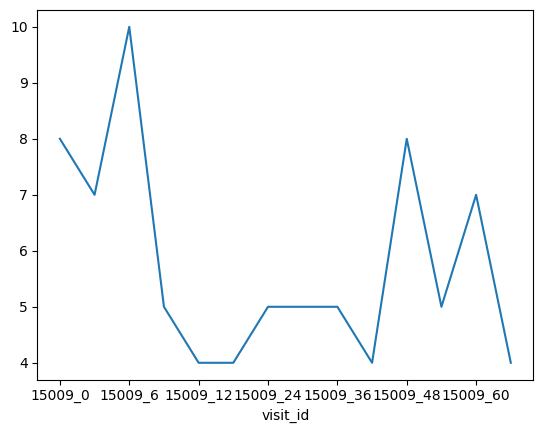

In [ ]:
train_df = train_df.set_index('visit_id')
train_df['updrs_1'].plot()



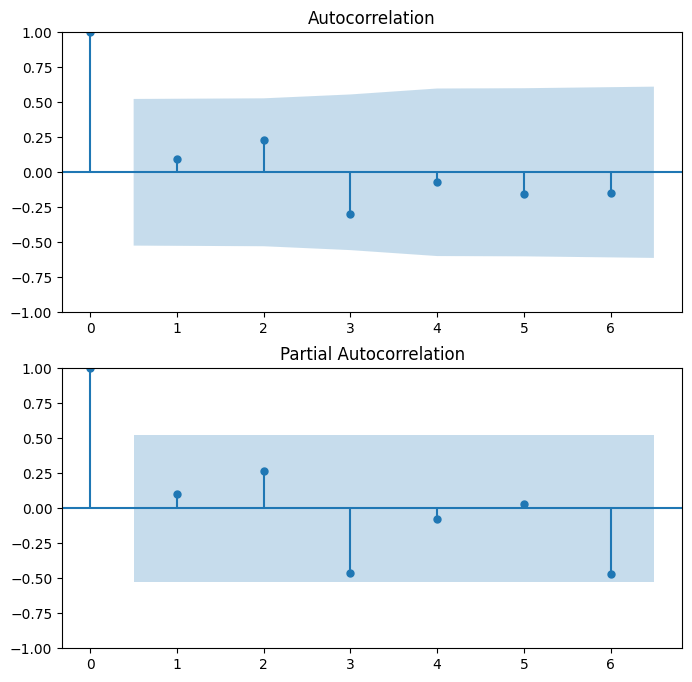

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
plot_acf(train_df, ax=ax1, lags=6)
plot_pacf(train_df, ax=ax2, lags=6)
plt.show()

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 17.5 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:

# fit the best ARIMA model
model = auto_arima(train_df['updrs_1'], start_p=0, start_d=0, start_q=1, max_p=6, max_d=1, max_q=6, 
                   seasonal=False, trace=True)

# print model summary
print(model.summary())

# get predictions for the test data
predictions = model.predict(n_periods=len(test_df))

# Calculate MAE and RMSE
mae = mean_absolute_error(test_df, predictions)
rmse = mean_squared_error(test_df, predictions, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)

Performing stepwise search to minimize aic
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=85.391, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=92.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=69.846, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=67.419, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=69.395, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=67.884, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=63.521, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=62.357, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=60.493, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=62.406, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=64.248, Time=0.07 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.623 seconds
                               SARIMAX Results        

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
model_1 = sm.tsa.ARIMA(train_df, order=(4, 0, 5))
results_1 = model_1.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likeliho

In [ ]:
results_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                updrs_1   No. Observations:                   14
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 -22.969
Date:                Mon, 24 Apr 2023   AIC                             67.937
Time:                        00:15:53   BIC                             74.967
Sample:                             0   HQIC                            67.287
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4420      0.270     20.134      0.000       4.912       5.972
ar.L1         -0.0305      2.262     -0.013      0.989      -4.465       4.404
ar.L2          0.6390      0.890      0.718      0.473      -1.106       2.384
ar.L3         -0.5482      0.608     -0.902      0.367      -1.739       0.643
ar.L4         -0.2190      1.234     -0.177      0.859      -2.638       2.200
ma.L1         -0.1695   2631.082  -6.44e-05      1.000   -5156.995    5156.656
ma.L2         -0.7321   2043.414     -0.000      1.000   -4005.749    4004.285
ma.L3         -0.7576     53.380     -0.014      0.989    -105.380     103.864
ma.L4         -0.1347   2226.116  -6.05e-05      1.000   -4363.243    4362.973
ma.L5          0.9836   2650.056      0.000      1.000   -5193.030    5194.997
sigma2         0.7128   1919.433      0.000      1.000   -3761.308    3762.733
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.09
Prob(Q):                              0.94   Prob(JB):                         0.58
Heteroskedasticity (H):               0.33   Skew:                             0.45
Prob(H) (two-sided):                  0.25   Kurtosis:                         1.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.4e+16. Standard errors may be unstable.
"""

In [ ]:
preds = results_1.forecast(steps=len(test_df))
preds = pd.DataFrame(preds)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
preds['visit_id'] = ["15009_84","15009_96","15009_108"]

In [ ]:
preds = preds.set_index('visit_id')

In [ ]:
test_df

,visit_id,updrs_1
593,15009_84,10.0
594,15009_96,18.0
595,15009_108,12.0


In [ ]:
mae = mean_absolute_error(test_df['updrs_1'], preds)
rmse = sqrt(mean_squared_error(test_df['updrs_1'], preds))

print("Mean absolute error: ", mae)
print("Root mean squared error: ", rmse)

Mean absolute error:  7.61981735564721
Root mean squared error:  8.619919963270238


In [ ]:
test_df = test_df.set_index('visit_id')

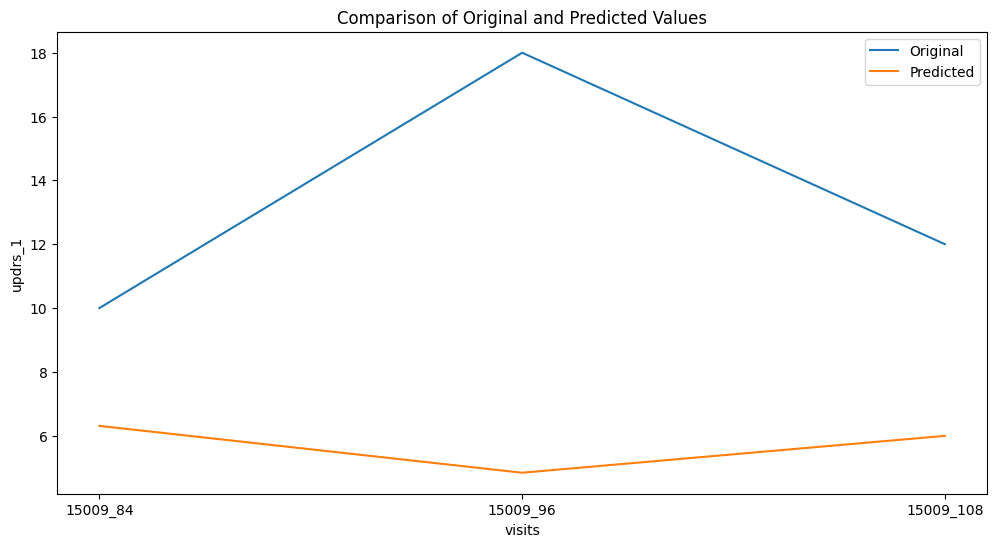

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_df.index, test_df.values, label='Original')
plt.plot(preds.index, preds.values, label='Predicted')
plt.title('Comparison of Original and Predicted Values')
plt.xlabel('visits')
plt.ylabel('updrs_1')
plt.legend()
plt.show()

In [ ]:
model_2 = sm.tsa.ARIMA(train_df, order=(0, 0, 0))
results_2 = model_2.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                updrs_1   No. Observations:                   14
Model:                          ARIMA   Log Likelihood                 -28.246
Date:                Mon, 24 Apr 2023   AIC                             60.493
Time:                        00:16:47   BIC                             61.771
Sample:                             0   HQIC                            60.374
                                 - 14                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7857      0.669      8.649      0.000       4.475       7.097
sigma2         3.3112      1.882      1.760      0.078      -0.377       6.999
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.70   Prob(JB):                         0.39
Heteroskedasticity (H):               0.48   Skew:                             0.89
Prob(H) (two-sided):                  0.44   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
preds_2 = results_2.forecast(steps=len(test_df))
preds_2 = pd.DataFrame(preds_2)

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
preds_2['visit_id'] = ["15009_84","15009_96","15009_108"]

Mean absolute error:  7.547623769165007
Root mean squared error:  8.277812520009144


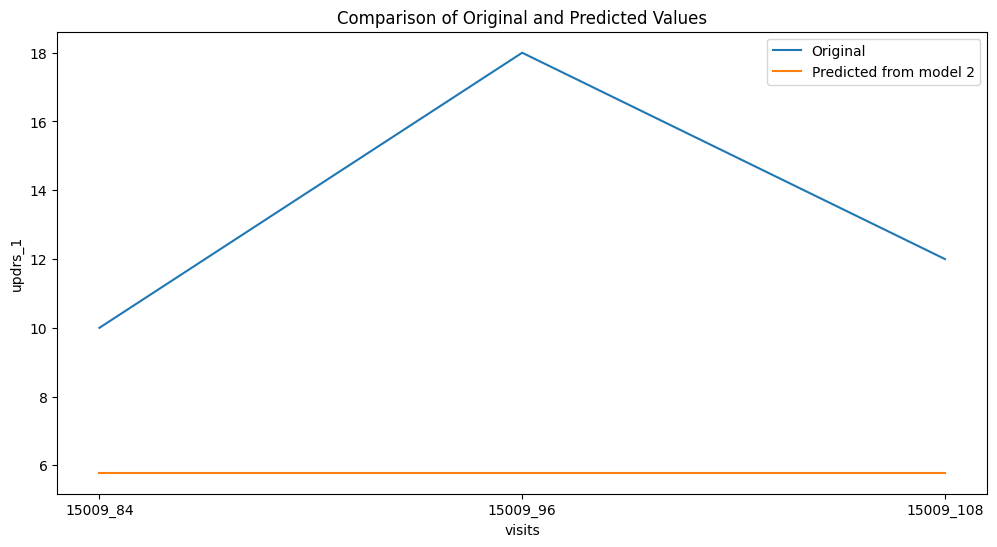

In [ ]:
preds_2 = preds_2.set_index('visit_id')
mae = mean_absolute_error(test_df['updrs_1'], preds_2)
rmse = sqrt(mean_squared_error(test_df['updrs_1'], preds_2))

print("Mean absolute error: ", mae)
print("Root mean squared error: ", rmse)


plt.figure(figsize=(12,6))
plt.plot(test_df.index, test_df.values, label='Original')
plt.plot(preds_2.index, preds_2.values, label='Predicted from model 2')
plt.title('Comparison of Original and Predicted Values')
plt.xlabel('visits')
plt.ylabel('updrs_1')
plt.legend()
plt.show()